In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# 1 load data 

In [2]:
mnist = tf.keras.datasets.mnist
(x_train_src,y_train_src),(x_test_src,y_test_src) = mnist.load_data('./mnist.npz')

In [3]:
print(x_train_src.shape,y_train_src.shape)
print(x_test_src.shape,y_test_src.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


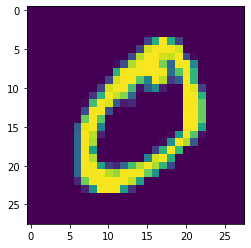

In [4]:
_,m,n = x_train_src.shape
plt.imshow(x_train_src[1,:,:])
plt.show()

# 2 feature //norm

In [5]:
x_train = x_train_src/255.
x_test = x_test_src/255.

y_train = y_train_src
y_test = y_test_src

# 3 model

In [41]:
num_h1 = 500
num_h2 = 500
num_h3 = 20
num_h4 = num_h2
num_h5 = num_h1
n_output = m*n

In [42]:
tf.reset_default_graph()

In [43]:
input_x = tf.placeholder(dtype=tf.float32,shape=[None,m,n],name='input_x')

In [44]:
x = tf.reshape(input_x,shape=[-1,m*n])

In [45]:
with tf.name_scope('h1'):
    w1 = tf.Variable(tf.truncated_normal(shape=[m*n,num_h1],mean=0.,\
                                     stddev=tf.sqrt(2.)*tf.sqrt(2./(m*n+num_h1))),dtype=tf.float32,\
                name = 'w1')
    b1 = tf.Variable(tf.zeros(shape=num_h1),name='b1',dtype=tf.float32)
    h1 = tf.matmul(x,w1) + b1

In [46]:
h1.shape

TensorShape([Dimension(None), Dimension(500)])

In [47]:
with tf.name_scope('h2'):
    w2 = tf.Variable(tf.truncated_normal(shape=[num_h1,num_h2],mean=0.,\
                                     stddev=tf.sqrt(2.)*tf.sqrt(2./(num_h2+num_h1))),dtype=tf.float32,\
                name = 'w2')
    b2 = tf.Variable(tf.zeros(shape=num_h2),name='b2',dtype=tf.float32)
    h2 = tf.matmul(h1,w2) + b2

In [96]:
## ！！分别根据h2 来拟合 因变量z 各个维度的均值和方差

In [49]:
with tf.name_scope('h3-mean'):
    w3 = tf.Variable(tf.truncated_normal(shape=[num_h2,num_h3],mean=0.,\
                                     stddev=tf.sqrt(2.)*tf.sqrt(2./(num_h2+num_h3))),dtype=tf.float32,\
                name = 'w3')
    b3 = tf.Variable(tf.zeros(shape=num_h3),name='b3',dtype=tf.float32)
    h3_mean = tf.matmul(h2,w3) + b3

In [50]:
with tf.name_scope('h3-gamma'):
    w3 = tf.Variable(tf.truncated_normal(shape=[num_h2,num_h3],mean=0.,\
                                     stddev=tf.sqrt(2.)*tf.sqrt(2./(num_h2+num_h3))),dtype=tf.float32,\
                name = 'w3')
    b3 = tf.Variable(tf.zeros(shape=num_h3),name='b3',dtype=tf.float32)
    h3_gamma = tf.matmul(h2,w3) + b3

In [51]:
h3_sigma = tf.exp(0.5*h3_gamma)

In [52]:
noise = tf.random_normal(tf.shape(h3_sigma),dtype=tf.float32)

In [53]:
h3 = h3_mean + h3_sigma*noise## elem-multi

In [54]:
with tf.name_scope('h4'):
    w4 = tf.Variable(tf.truncated_normal(shape=[num_h3,num_h4],mean=0.,\
                                     stddev=tf.sqrt(2.)*tf.sqrt(2./(num_h3+num_h4))),dtype=tf.float32,\
                name = 'w4')
    b4 = tf.Variable(tf.zeros(shape=num_h4),name='b4',dtype=tf.float32)
    h4 = tf.matmul(h3,w4) + b4

In [55]:
with tf.name_scope('h5'):
    w5 = tf.Variable(tf.truncated_normal(shape=[num_h4,num_h5],mean=0.,\
                                     stddev=tf.sqrt(2.)*tf.sqrt(2./(num_h4+num_h5))),dtype=tf.float32,\
                name = 'w5')
    b5 = tf.Variable(tf.zeros(shape=num_h5),name='b5',dtype=tf.float32)
    h5 = tf.matmul(h4,w5) + b5

In [57]:
with tf.name_scope('output'):
    wo = tf.Variable(tf.truncated_normal(shape=[num_h5,n_output],mean=0.,\
                                     stddev=tf.sqrt(2.)*tf.sqrt(2./(num_h5+n_output))),dtype=tf.float32,\
                name = 'wo')
    bo = tf.Variable(tf.zeros(shape=n_output),name='bo',dtype=tf.float32)
    output = tf.sigmoid(tf.matmul(h5,wo) + bo)

# 4 loss

In [58]:
reconstruction_loss = tf.reduce_sum(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=output))
    

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [60]:
latent_loss = 0.5 * tf.reduce_sum(
        tf.exp(h3_gamma) + tf.square(h3_mean) - 1 - h3_gamma)   

In [62]:
loss = reconstruction_loss + latent_loss

# 5 optimize

In [63]:
adam = tf.train.AdamOptimizer(learning_rate=3e-4)

In [64]:
train_op = adam.minimize(loss)

# 6 init

In [65]:
init_op = tf.global_variables_initializer()

# 7 train

In [66]:
saver = tf.train.Saver()

In [67]:
num_epochs = 10
batch_size = 128
num_batch = int(x_train.shape[0]/128) + 1

In [68]:
def feed_batch(n_epochs,batch_index,batch_size,x_train,y_train):
    beg = (batch_index -1 )* batch_size
    end = batch_index * batch_size;
    
    return x_train[beg:end],y_train[beg:end],np.array([i.shape[0] for i in x_train[beg:end]])

In [70]:
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(num_epochs):
        for j in range(1,num_batch):
            sample_x,sample_y,sample_len = feed_batch(i,j,batch_size,x_train,y_train)
            train_loss,_= sess.run([loss,train_op],feed_dict={input_x:sample_x})
            if j%100 == 0:
                print('%d,%dth:loss is %f'%(i,j,train_loss))
    train_losss = sess.run([loss],feed_dict={input_x:x_train})
    print('final loss%f'%(train_loss))
    saver.save(sess,'./model/vae')

0,100th:loss is 70556.710938
0,200th:loss is 70240.023438
0,300th:loss is 70313.500000
0,400th:loss is 70105.382812
1,100th:loss is 69813.062500
1,200th:loss is 69689.460938
1,300th:loss is 69653.437500
1,400th:loss is 69580.054688
2,100th:loss is 69586.789062
2,200th:loss is 69531.898438
2,300th:loss is 69577.500000
2,400th:loss is 69518.015625
3,100th:loss is 69597.906250
3,200th:loss is 69486.570312
3,300th:loss is 69578.437500
3,400th:loss is 69478.718750
4,100th:loss is 69562.140625
4,200th:loss is 69474.796875
4,300th:loss is 69587.164062
4,400th:loss is 69467.554688
5,100th:loss is 69588.273438
5,200th:loss is 69386.960938
5,300th:loss is 69552.859375
5,400th:loss is 69389.843750
6,100th:loss is 69571.570312
6,200th:loss is 69399.882812
6,300th:loss is 69539.492188
6,400th:loss is 69348.195312
7,100th:loss is 69551.367188
7,200th:loss is 69302.500000
7,300th:loss is 69560.445312
7,400th:loss is 69304.007812
8,100th:loss is 69526.531250
8,200th:loss is 69273.695312
8,300th:loss i

# 8 eval

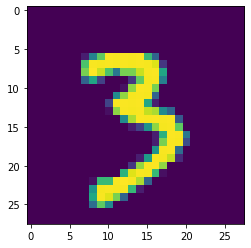

In [72]:
plt.imshow(x_test_src[30,:,:])
plt.show()

In [75]:
tf.reset_default_graph()

In [79]:
with tf.Session() as sess:
    ##import granph define
    new_saver = tf.train.import_meta_graph('./model/vae.meta')
    new_saver.restore(sess,'./model/vae')
    graph = tf.get_default_graph()
    for op in graph.get_operations():
        #print(op.name)
        pass
    ##output
    x = graph.get_tensor_by_name('input_x:0')
    h3 = graph.get_tensor_by_name('add:0')
    out = graph.get_tensor_by_name('output_1/Sigmoid:0')
    new_image,embed = sess.run([out,h3],feed_dict={x:x_test_src[30,:,:].reshape(-1,28,28)})

INFO:tensorflow:Restoring parameters from ./model/vae


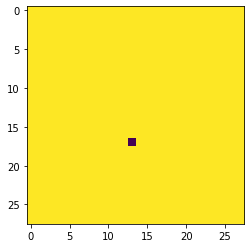

In [80]:
plt.imshow((new_image.reshape(28,28)*255.))
plt.show()

## 2 generate new image

In [82]:
num_dits = 10

In [94]:
with tf.Session() as sess:
    ##import granph define
    new_saver = tf.train.import_meta_graph('./model/vae.meta')
    new_saver.restore(sess,'./model/vae')
    graph = tf.get_default_graph()
    for op in graph.get_operations():
        #print(op.name)
        pass
    ##output
    
    x = graph.get_tensor_by_name('input_x:0')
    h3 = graph.get_tensor_by_name('add:0')
    out = graph.get_tensor_by_name('output_1/Sigmoid:0')
    codings_rnd = np.random.normal(size=[num_dits, num_h3])
    new_image = sess.run(out,feed_dict={h3:codings_rnd})

INFO:tensorflow:Restoring parameters from ./model/vae


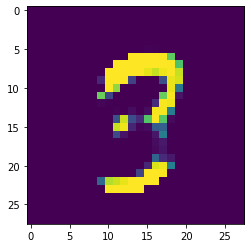

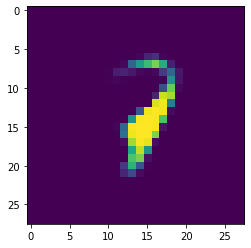

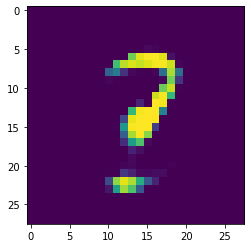

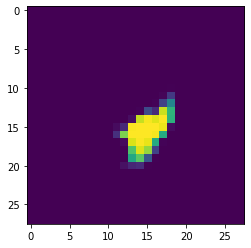

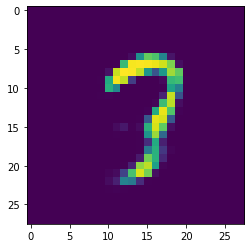

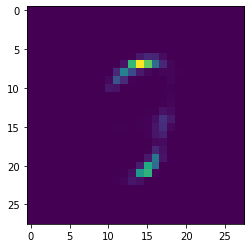

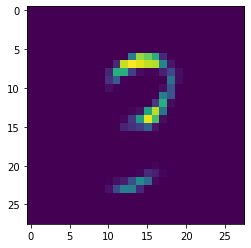

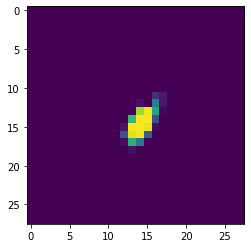

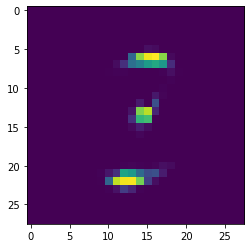

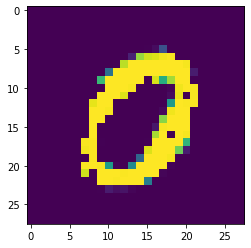

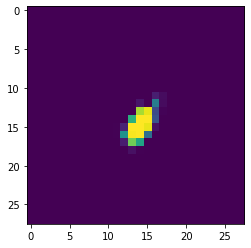

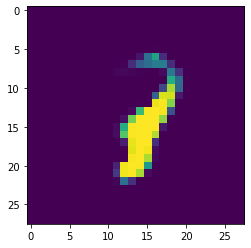

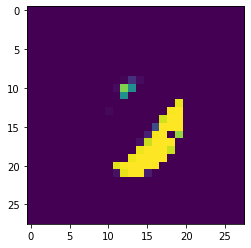

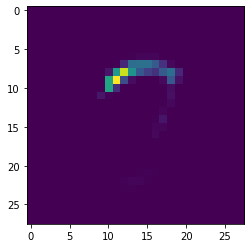

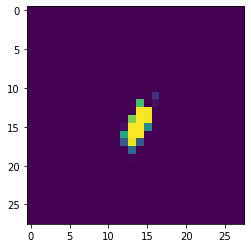

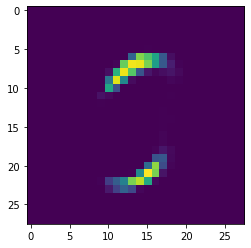

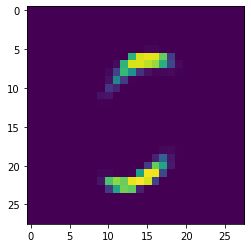

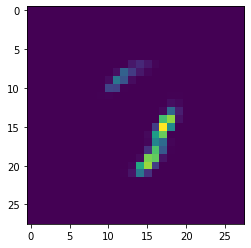

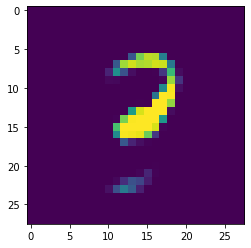

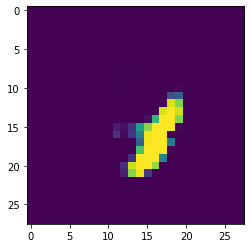

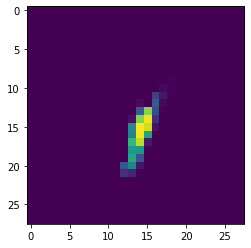

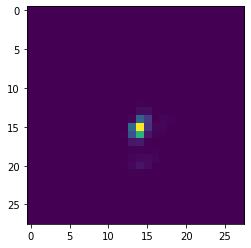

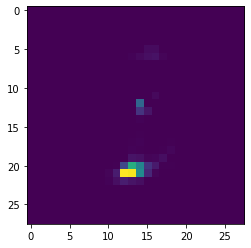

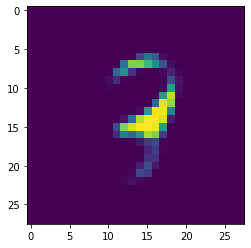

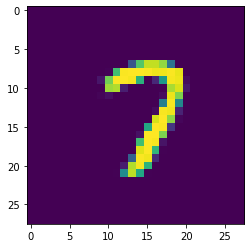

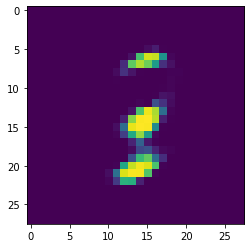

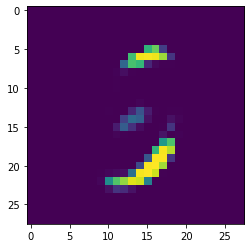

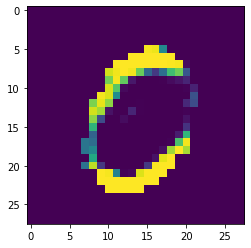

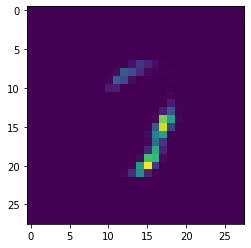

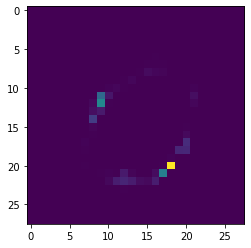

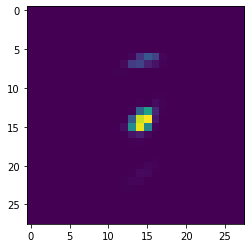

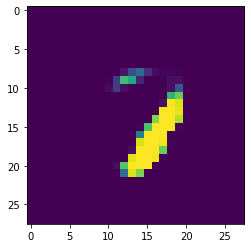

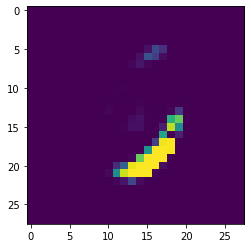

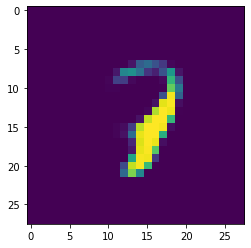

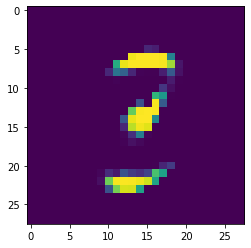

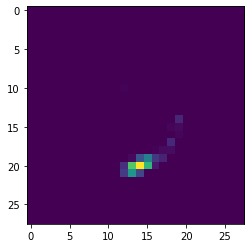

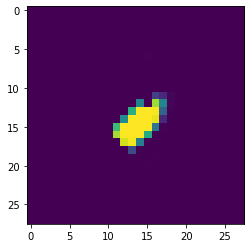

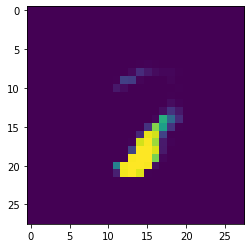

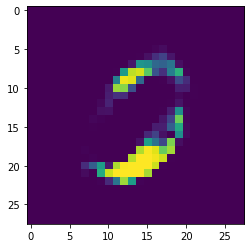

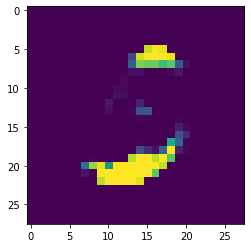

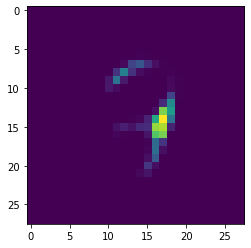

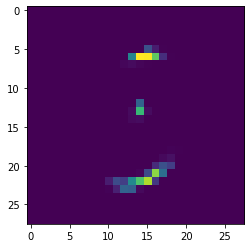

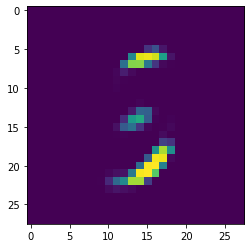

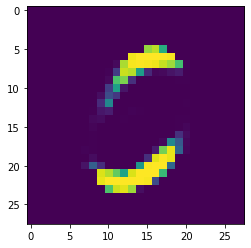

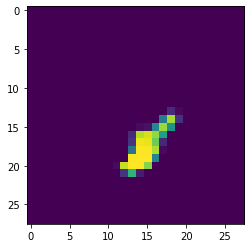

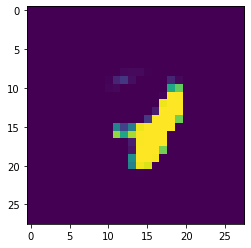

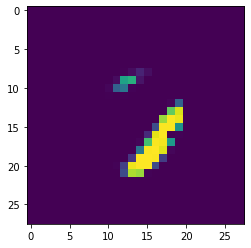

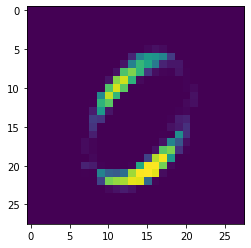

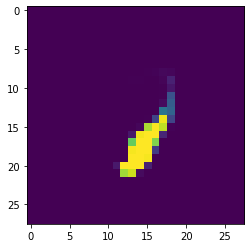

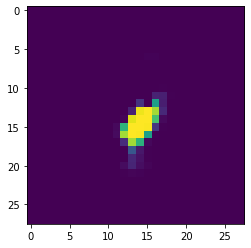

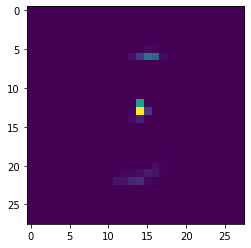

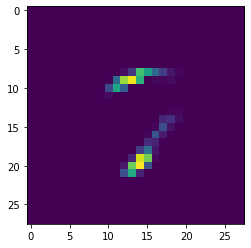

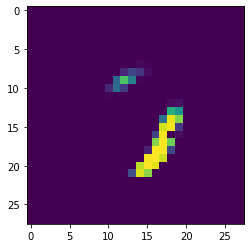

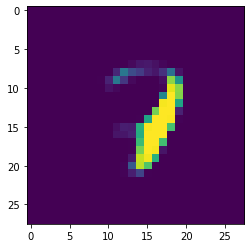

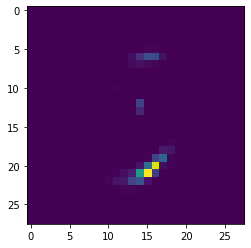

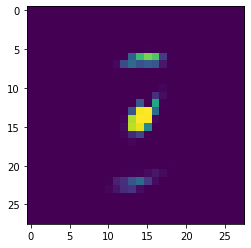

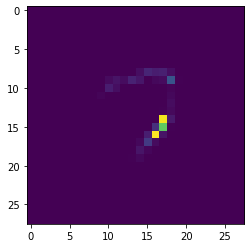

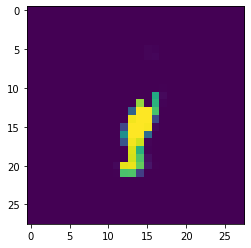

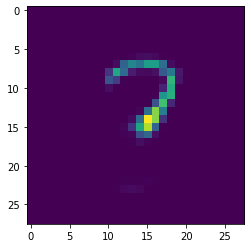

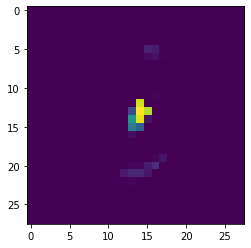

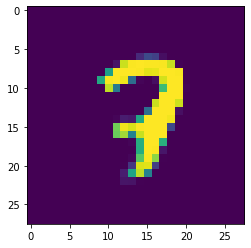

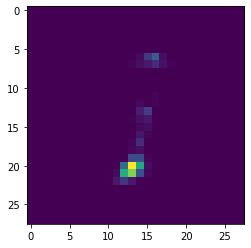

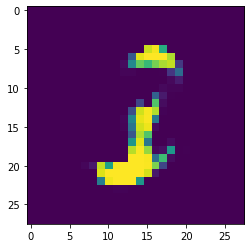

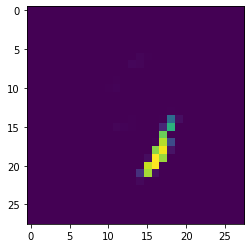

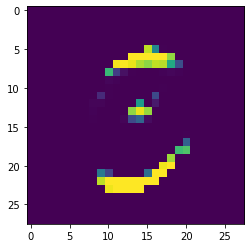

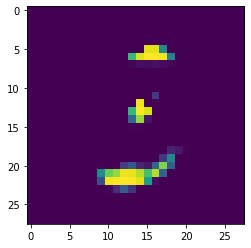

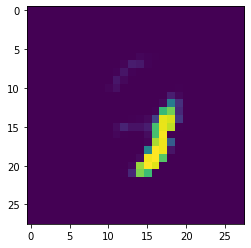

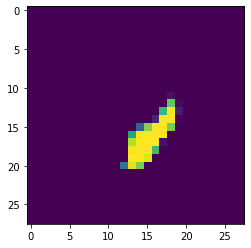

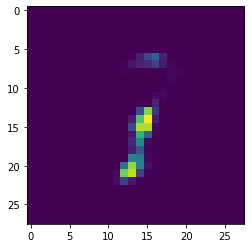

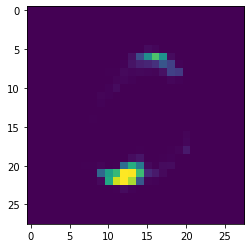

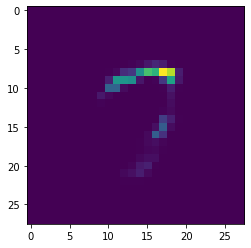

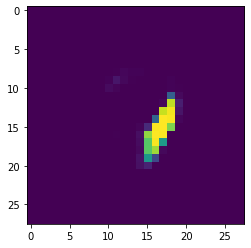

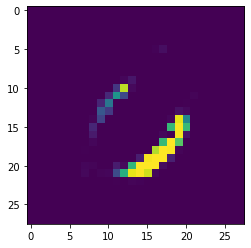

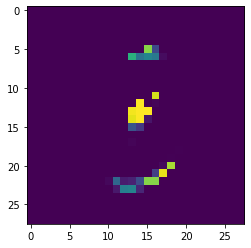

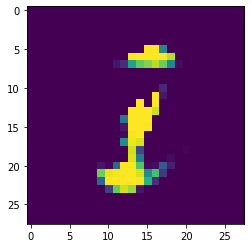

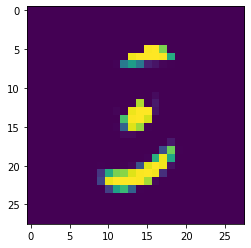

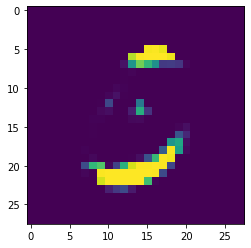

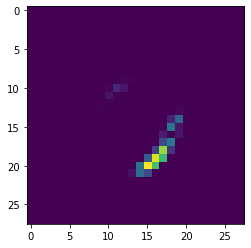

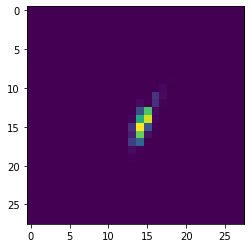

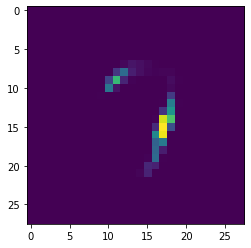

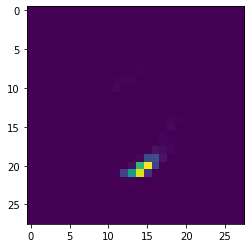

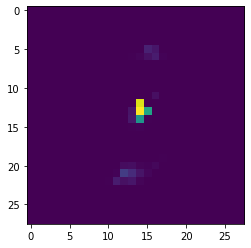

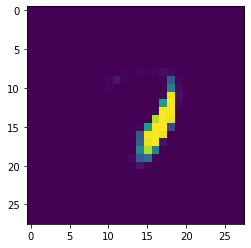

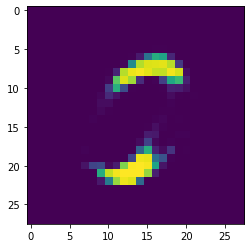

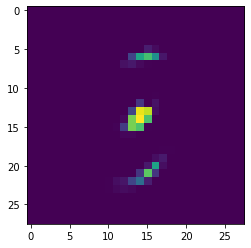

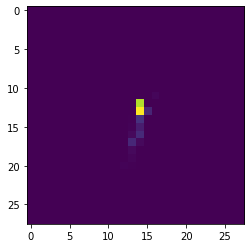

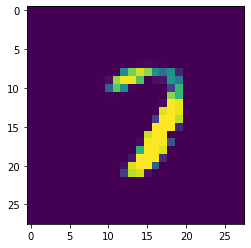

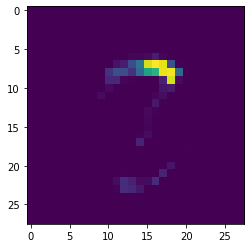

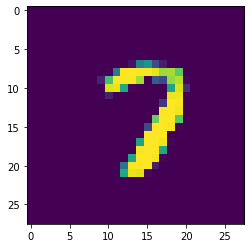

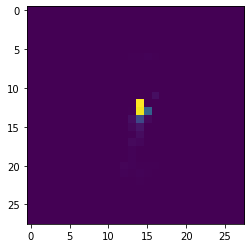

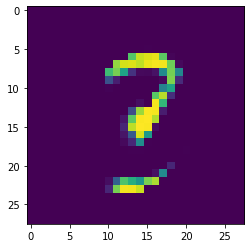

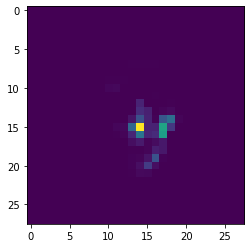

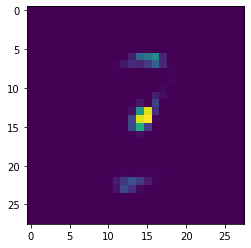

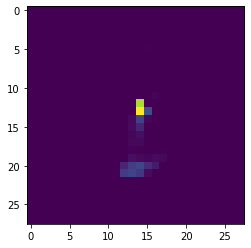

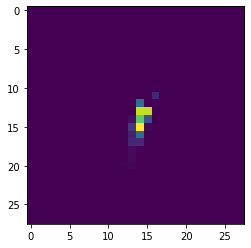

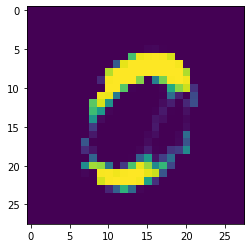

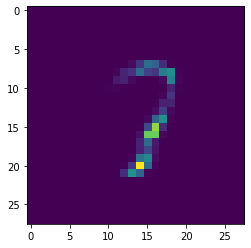

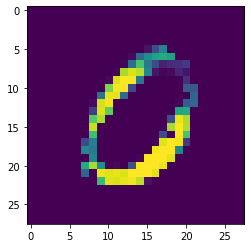

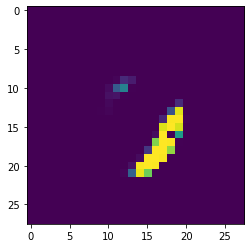

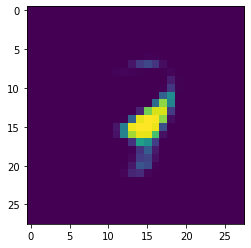

In [95]:
for i in range(num_dits):
    plt.imshow((new_image[i].reshape(28,28)*255.))
    plt.show()

In [93]:
new_image[0].shape

(100, 784)